In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as m
from torch.utils.data import DataLoader
from transforms import *
from torchvision.transforms import Compose
from torchsummary import summary
from random_caption_dataset import RandomCaptionDataset
from text_preprocessing import *
from inference import *
import matplotlib.pyplot as plt

print(f'PyTorch version: {torch.__version__}')
print("GPU found :)" if torch.cuda.is_available() else "No GPU :(")

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

PyTorch version: 1.7.1
GPU found :)


In [2]:
IMAGE_SIZE = 224
EMBEDDING_SIZE = 512
CONTEXT_SIZE = 4
train_annotations_file = './flickr8k/annotations/annotations_image_id_train.csv'
test_annotations_file = './flickr8k/annotations/annotations_image_id_test.csv'

In [3]:
# Init text preprocessing class
tp = TextPreprocessor(train_annotations_file, sep=';')

In [4]:
# retrieve pretrained model for features extraction
base_cnn = m.resnet18(pretrained=True)
# Keep only the feature extraction layers of the model
cnn = nn.Sequential(*(list(base_cnn.children())[:-1])).to(device, dtype=torch.float)

In [5]:
vocab_size = tp.vocab_size
print(vocab_size)

# RNN with LSTM of  layer
class LSTMCaptioning(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMCaptioning, self).__init__()
        
        # Random init the lstm state
        self.h0 = torch.zeros((num_layers, batch_size, hidden_size)).to(device)
        self.c0 = torch.zeros((num_layers, batch_size, hidden_size)).to(device)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, dropout=0.5)
        self.hidden2out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, previous_state=None):
         
        if previous_state is None:
            previous_state = (self.h0, self.c0)
            
        # Get hidden states for each t (out) , and latest one (h = (ht, ct))
        lstm_out, (hn, cn) = self.lstm(x, previous_state)
        
        # Convert output of rnn to output targeted size
        out = self.hidden2out(lstm_out.view(1, -1))
        
        # Compute probability distribution over all words for this t
        pt = F.log_softmax(out, dim=1)
                           
        return (hn, cn), pt

# Need to copy class here to load trained Ngram model    
class NGram(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGram, self).__init__()
        
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        
        embeds = self.embeddings(inputs).view(len(inputs), -1)
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        
        return log_probs


# Not trained embedding layer to encode words to hidden space
#embedding = nn.Embedding(vocab_size, EMBEDDING_SIZE).to(device)

# Load model for evaluation
ngram_model = NGram(vocab_size, EMBEDDING_SIZE, CONTEXT_SIZE)
ngram_model.load_state_dict(torch.load('./models/ngram_512_v1'))

embedding = list(ngram_model.children())[0].to(device)

8255


In [6]:
input_size = EMBEDDING_SIZE
hidden_size = 512
num_layers = 3
batch_size = 1

model = LSTMCaptioning(input_size, hidden_size, vocab_size, num_layers).to(device, dtype=torch.float)
model.load_state_dict(torch.load('./models/model_random_v2_init0_lstm3'))
model.to(device)

LSTMCaptioning(
  (lstm): LSTM(512, 512, num_layers=3, dropout=0.5)
  (hidden2out): Linear(in_features=512, out_features=8255, bias=True)
)

In [7]:
# Create test loaders for datasets

# Only preprocess images
test_transforms = Compose([Rescale(256), 
                      RandomCrop(IMAGE_SIZE), 
                      ToTensor(), 
                      Normalize()])

test_random_dataset_unformatted = RandomCaptionDataset('./flickr8k/images/test', test_annotations_file)
train_random_dataset_unformatted = RandomCaptionDataset('./flickr8k/images/train', train_annotations_file)


test_random_dataset = RandomCaptionDataset('./flickr8k/images/test', test_annotations_file, transform=test_transforms)
train_random_dataset = RandomCaptionDataset('./flickr8k/images/train/', train_annotations_file, transform=test_transforms)

test_random_loader = DataLoader(test_random_dataset, batch_size=batch_size)

In [12]:
image = train_random_dataset[3000]['image'].view(1, 3, IMAGE_SIZE, IMAGE_SIZE).to(device, dtype=torch.float)
caption = train_random_dataset[3000]['caption']
captions = sampling(cnn, embedding, model, image, tp, EMBEDDING_SIZE, hidden_size)
print(caption)
captions

<start> A person is sitting near smooth rocks on a stream bed . <stop>


'<start> A man in a blue jacket and jacket and a black jacket is on a skateboard . <stop>'

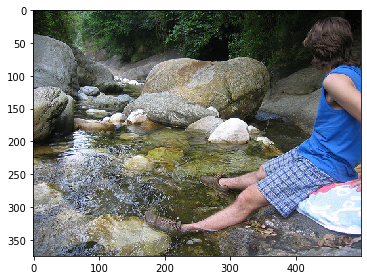

In [11]:
from skimage import io
image = train_random_dataset_unformatted[3000]['image']
io.imshow(image)

In [ ]:
with torch.no_grad():

    for i, sample in enumerate(test_random_loader):
         
        # Get the input of the text generator
        image = sample['image'].view(1, 3, IMAGE_SIZE, IMAGE_SIZE).to(device, dtype=torch.float)

        # Get the generated sentence
        pred = sampling(cnn, embedding, model, image, tp, EMBEDDING_SIZE, hidden_size)
        
    